In [ ]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import cv2
import os
from tensorflow.keras.layers import Conv2D, MaxPooling2D, UpSampling2D, Concatenate, Input
from tensorflow.keras.models import Model
from sklearn.model_selection import train_test_split


In [3]:
# Set dataset path
IMAGE_SIZE = 256  # Resize images to 128x128
DATASET_PATH = "/kaggle/input/brain-tumor-segmentation"

def load_data(image_path, mask_path):
    images = []
    masks = []
    
    image_files = sorted(os.listdir(image_path))
    mask_files = sorted(os.listdir(mask_path))
    
    for img_file, mask_file in zip(image_files, mask_files):
        # Load image in color, convert to RGB, and resize
        img = cv2.imread(os.path.join(image_path, img_file)) 
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (IMAGE_SIZE, IMAGE_SIZE))
        img = img / 255.0  # Normalize
        
        mask = cv2.imread(os.path.join(mask_path, mask_file), cv2.IMREAD_GRAYSCALE)
        mask = cv2.resize(mask, (IMAGE_SIZE, IMAGE_SIZE))
        mask = mask / 255.0  # Normalize
        
        images.append(img)
        masks.append(mask)
    
    return np.array(images), np.array(masks)

# Paths to images and masks
image_path = os.path.join(DATASET_PATH, "images")  # Change according to dataset
mask_path = os.path.join(DATASET_PATH, "masks")

# Load dataset
X, Y = load_data(image_path, mask_path)



# Train-Test Split
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.2, random_state=42)
# Print shapes of training and validation sets
print("X_train shape:", X_train.shape)
print("Y_train shape:", Y_train.shape)
print("X_val shape:", X_val.shape)
print("Y_val shape:", Y_val.shape)


X_train shape: (2451, 256, 256, 3)
Y_train shape: (2451, 256, 256)
X_val shape: (613, 256, 256, 3)
Y_val shape: (613, 256, 256)


In [4]:
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, MaxPool2D, Conv2DTranspose, Concatenate, Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

def conv_block(inputs, num_filters):
    x = Conv2D(num_filters, 3, padding="same")(inputs)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = Conv2D(num_filters, 3, padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    return x

def encoder_block(inputs, num_filters):
    x = conv_block(inputs, num_filters)
    p = MaxPool2D((2, 2))(x)
    return x, p

def decoder_block(inputs, skip_features, num_filters):
    x = Conv2DTranspose(num_filters, 2, strides=2, padding="same")(inputs)
    x = Concatenate()([x, skip_features])
    x = conv_block(x, num_filters)
    return x

def build_reduced_unet(input_shape):
    inputs = Input(input_shape)

    s1, p1 = encoder_block(inputs, 16)
    s2, p2 = encoder_block(p1, 32)
    s3, p3 = encoder_block(p2, 64)

    b1 = conv_block(p3, 512)

    d1 = decoder_block(b1, s3, 64)
    d2 = decoder_block(d1, s2, 32)
    d3 = decoder_block(d2, s1, 16)

    outputs = Conv2D(1, 1, padding="same", activation="sigmoid")(d3)

    model = Model(inputs, outputs, name="Reduced_UNET")
    model.compile(optimizer=Adam(learning_rate=0.0001), loss="binary_crossentropy", metrics=["accuracy"])
    
    return model

if __name__ == "__main__":
    input_shape = (256, 256, 3)
    model = build_reduced_unet(input_shape)
    model.summary()


Model: "Reduced_UNET"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 256, 256, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 256, 256, 16)   │            448 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 256, 256, 16)   │             64 │ conv2d[0][0]           │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation (Activation)   │ (None, 256, 256, 16)   │              0 │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 256, 256, 16)   │          2,320 │ activation[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 256, 256, 16)   │             64 │ conv2d_1[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_1 (Activation) │ (None, 256, 256, 16)   │              0 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 128, 128, 16)   │              0 │ activation_1[0][0]     │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 128, 128, 32)   │          4,640 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_2     │ (None, 128, 128, 32)   │            128 │ conv2d_2[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_2 (Activation) │ (None, 128, 128, 32)   │              0 │ batch_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 128, 128, 32)   │          9,248 │ activation_2[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_3     │ (None, 128, 128, 32)   │            128 │ conv2d_3[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_3 (Activation) │ (None, 128, 128, 32)   │              0 │ batch_normalization_3… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_1           │ (None, 64, 64, 32)     │              0 │ activation_3[0][0]     │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 64, 64, 64)     │         18,496 │ max_pooling2d_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_4

 Total params: 3,020,017 (11.52 MB)

 Trainable params: 3,017,073 (11.51 MB)

 Non-trainable params: 2,944 (11.50 KB)

In [5]:
# Train U-Net Model
# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy']) 

history = model.fit(
    X_train, Y_train,
    validation_data=(X_val, Y_val),
    epochs=50,
    batch_size=16
)

Epoch 1/50
154/154 ━━━━━━━━━━━━━━━━━━━━ 48s 168ms/step - accuracy: 0.9505 - loss: 0.3014 - val_accuracy: 0.9823 - val_loss: 0.2299
Epoch 2/50
154/154 ━━━━━━━━━━━━━━━━━━━━ 13s 85ms/step - accuracy: 0.9826 - loss: 0.1047 - val_accuracy: 0.9545 - val_loss: 0.1467
Epoch 3/50
154/154 ━━━━━━━━━━━━━━━━━━━━ 13s 85ms/step - accuracy: 0.9845 - loss: 0.0675 - val_accuracy: 0.9823 - val_loss: 0.0833
Epoch 4/50
154/154 ━━━━━━━━━━━━━━━━━━━━ 13s 85ms/step - accuracy: 0.9869 - loss: 0.0486 - val_accuracy: 0.9818 - val_loss: 0.0803
Epoch 5/50
154/154 ━━━━━━━━━━━━━━━━━━━━ 13s 84ms/step - accuracy: 0.9880 - loss: 0.0407 - val_accuracy: 0.9828 - val_loss: 0.0499
Epoch 6/50
154/154 ━━━━━━━━━━━━━━━━━━━━ 13s 85ms/step - accuracy: 0.9883 - loss: 0.0367 - val_accuracy: 0.9856 - val_loss: 0.0456
Epoch 7/50
154/154 ━━━━━━━━━━━━━━━━━━━━ 13s 85ms/step - accuracy: 0.9889 - loss: 0.0325 - val_accuracy: 0.9899 - val_loss: 0.0302
Epoch 8/50
154/154 ━━━━━━━━━━━━━━━━━━━━ 13s 85ms/step - accuracy: 0.9897 - loss: 0.0300 -

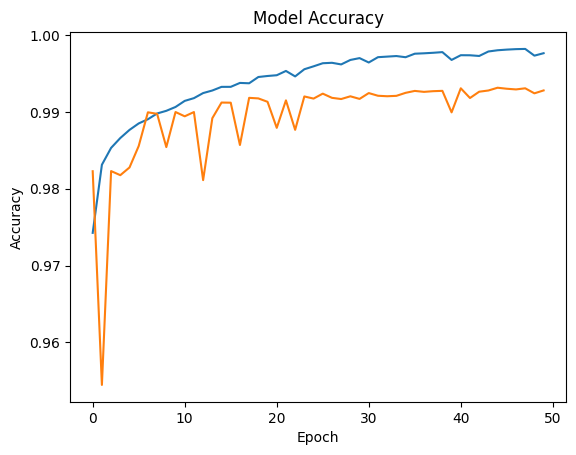

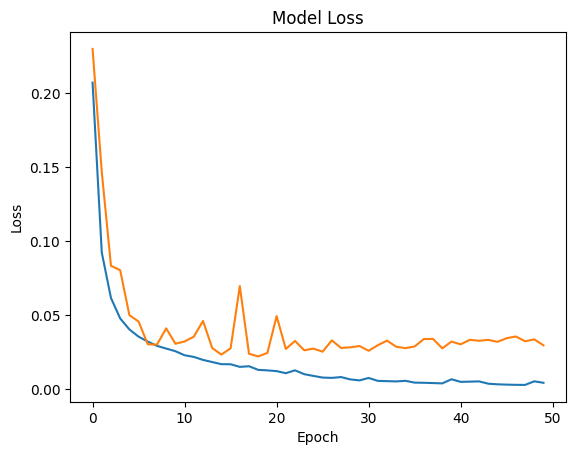

In [6]:
import matplotlib.pyplot as plt

# Plot accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.show()

# Plot loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


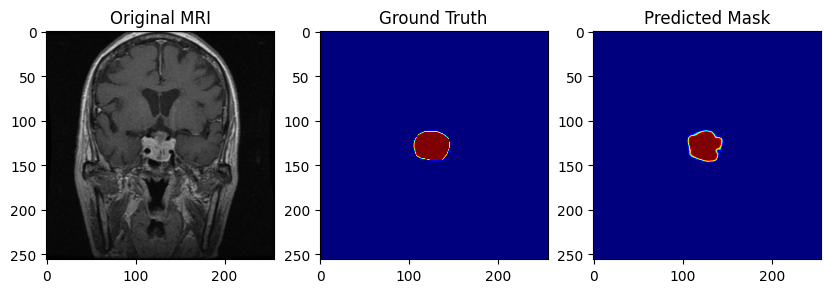

In [7]:
# Function to visualize results
def visualize_prediction(model, X_test, Y_test, index=0):
    pred_mask = model.predict(X_test[index:index+1])[0]

    plt.figure(figsize=(10, 5))

    plt.subplot(1, 3, 1)
    plt.imshow(X_test[index].squeeze(), cmap='gray')
    plt.title("Original MRI")

    plt.subplot(1, 3, 2)
    plt.imshow(Y_test[index].squeeze(), cmap='jet')
    plt.title("Ground Truth")

    plt.subplot(1, 3, 3)
    plt.imshow(pred_mask.squeeze(), cmap='jet')
    plt.title("Predicted Mask")

    plt.show()

# Test on sample image
visualize_prediction(model, X_val, Y_val, index=5)


In [8]:
# Evaluate the model
loss, accuracy = model.evaluate(X_val, Y_val)

# Print results
print(f"Validation Loss: {loss:.4f}")
print(f"Validation Accuracy: {accuracy:.4f}")

20/20 ━━━━━━━━━━━━━━━━━━━━ 5s 48ms/step - accuracy: 0.9927 - loss: 0.0293
Validation Loss: 0.0296
Validation Accuracy: 0.9928


In [9]:
model.save("/kaggle/working/brain_tumor_segmentation_unet.h5")
print("Model saved successfully!")

Model saved successfully!
